In [71]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/march/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [231]:
import tensorflow as tf
import os
import random
import collections
import glob
import sys
import IPython
from scipy.io import wavfile
from scipy import signal

## Explorando el dataset

### Muchas Baterías

In [43]:
drums = [d for d in os.listdir('drums') if os.path.isdir(os.path.join('drums', d))]
print '#Drums: ', len(drums)
print 
for d in random.sample(drums, 10):
    print d

#Drums:  200

Visco Space drums
Kawai R-100
Alesis DM5
Roland JD-990
Kurzweil K2000 ROM
AKAI XE-8
Roland SC-88
Casio RZ-1
Wersi WM 24
Roland DDR30


### Muchos sonidos

In [135]:
all_dirs = [d_dir for d_dir in os.listdir('drums') if os.path.isdir(os.path.join('drums', d_dir))]
all_wavs = [os.path.join('drums', d_dir, wf)
            for d_dir in all_dirs 
            for wf in os.listdir(os.path.join('drums', d_dir)) if wf.endswith('.wav')]
print '#(**/*.wav): ', len(all_wavs)
print
print 'Subtipos:'
drum_types = ['crash', 'tom', 'hat', 'snare', 'kick']
for dt in drum_types:
    print '#(**/*{}*.wav): {}'.format(dt, len([wf for wf in all_wavs if os.path.basename(wf).lower().find(dt) > 0]))

#(**/*.wav):  6750

Subtipos:
#(**/*crash*.wav): 77
#(**/*tom*.wav): 487
#(**/*hat*.wav): 290
#(**/*snare*.wav): 612
#(**/*kick*.wav): 458


In [95]:
selected = random.sample(all_wavs, 6)
for wf in selected:
    print wf
    IPython.display.display(IPython.display.Audio(wf))

drums/Akai XR10/XR10MidTom02.wav


drums/Roland MC09/MC09 HatO_05.wav


drums/Emu Drumulator/DrumulatorSnare01.wav


drums/Vox Drumbox/MaxV - Wood.wav


drums/Roland JD800/JD800 Internal Drums 015.wav


drums/Kawai R-100/MaxV - PERC-CH3.wav


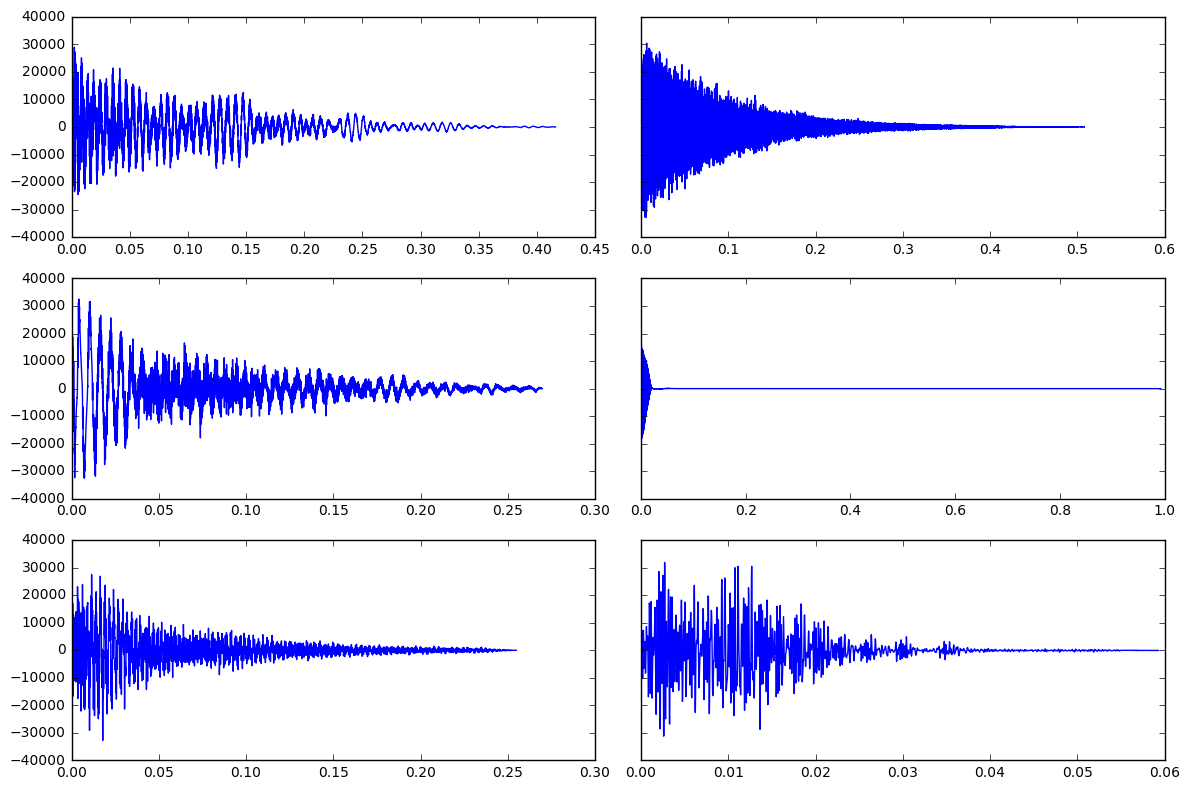

In [96]:
fig, axs = subplots(3, 2, sharey=True, figsize=(12, 8))
for ax, wf in zip(axs.reshape((6,)), selected):
    sr, w_signal = wavfile.read(wf)
    xs = arange(len(w_signal)) / float(sr)
    sca(ax)
    plot(xs, w_signal)
tight_layout()

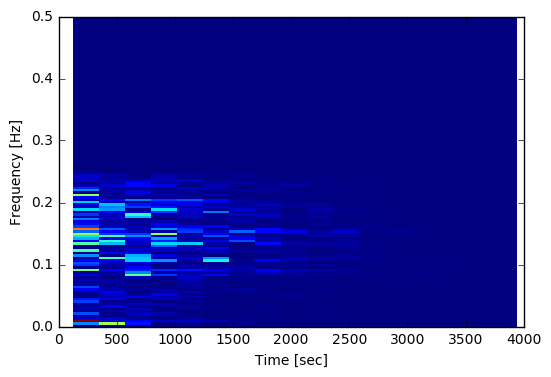

In [73]:

s = selected[0]


### Dataset resumido

In [216]:
srs = []
durs = []
chs = []
valid_wavs = []
for wf in all_wavs:
    try:
        sr, w_signal = wavfile.read(wf)
        srs.append(sr)
        chs.append(w_signal.shape[1] if len(w_signal.shape) > 1 else 1)
        durs.append(len(w_signal) / float(sr))
        valid_wavs.append(wf)
    except Exception as e:
        print wf
assert len(set(chs)) == 1 and chs[0] == 1
assert all(durs > 0)

drums/Roland JV 1080/MaxV - Guiro.wav


set([44100])


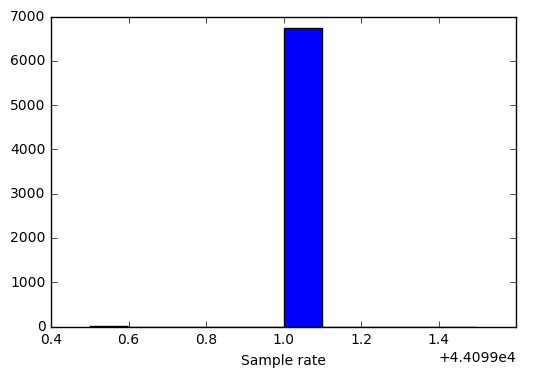

In [224]:
# Plot srs
srs = np.array(srs)
srs = srs
hist(srs)
xlabel('Sample rate')

print set(srs)
global_sr = srs[0]

Min durations (seg): [0.0003401360544217687, 0.0023356009070294786, 0.003038548752834467, 0.003061224489795918, 0.003832199546485261, 0.003832199546485261, 0.003832199546485261, 0.003832199546485261, 0.003832199546485261, 0.003945578231292517]
Max durations (seg): [14.68, 14.914081632653062, 16.211269841269843, 17.286780045351474, 18.812879818594105, 19.508049886621315, 21.005963718820862, 21.10426303854875, 21.116938775510203, 39.78546485260771]


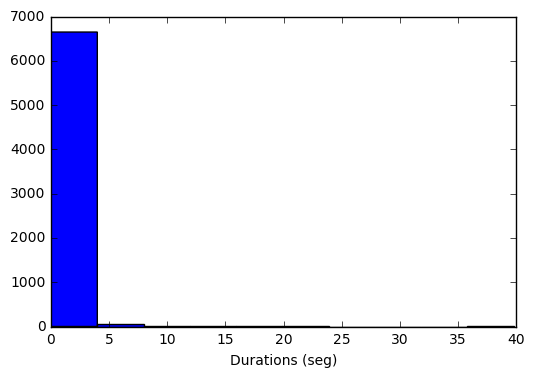

In [218]:
s_durs = sorted(durs)
print 'Min durations (seg):', s_durs[:10]
print 'Max durations (seg):', s_durs[-10:]
# Plot durs
hist(s_durs)
xlabel('Durations (seg)')

Count: 5834 (0.86%)


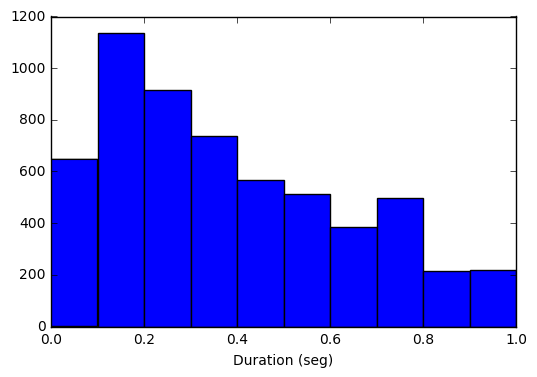

In [219]:
bins_l = linspace(0, 1, num=11)
under_sec = [d for d in s_durs if d <= 1]
hist(under_sec, bins=bins_l)
xlabel('Duration (seg)')
print 'Count: {} ({:.2f}%)'.format(len(under_sec), len(under_sec) / float(len(durs)))

In [220]:
under_sec_wavs = [wf for wf, dur in zip(valid_wavs, durs) if dur <= 1]

### Por tipos de ruido

In [233]:
by_type = collections.OrderedDict([(dt, []) for dt in drum_types + ['others']])

for wf in under_sec_wavs:
    is_of_type = False
    for dt in drum_types:
        if os.path.basename(wf).lower().find(dt) > 0:
            by_type[dt].append(wf)
            is_of_type = True
    if not is_of_type:
        by_type['others'].append(wf)

print '#total:', len(under_sec_wavs)
print
for k, v in by_type.items():
    print '#{}: {}'.format(k, len(v))

#total: 5834

#crash: 17
#tom: 419
#hat: 256
#snare: 587
#kick: 442
#others: 4113


In [234]:
intersections = [((k, k2), set(by_type[k]).intersection(set(by_type[k2])))
                 for idx, k in enumerate(by_type.keys())
                 for k2 in by_type.keys()[:idx]]
assert len([x for x in intersections if len(x[1]) > 0]) == 0  # Los conjuntos son disjuntos

In [235]:
by_type_avg = dict([(k, np.zeros(global_sr)) for k in by_type.keys()])
for k, values in by_type.items():
    for wf in values:
        _, w_signal = wavfile.read(wf)
        by_type_avg[k][:len(w_signal)] += w_signal
    by_type_avg[k] = by_type_avg[k] / len(values)

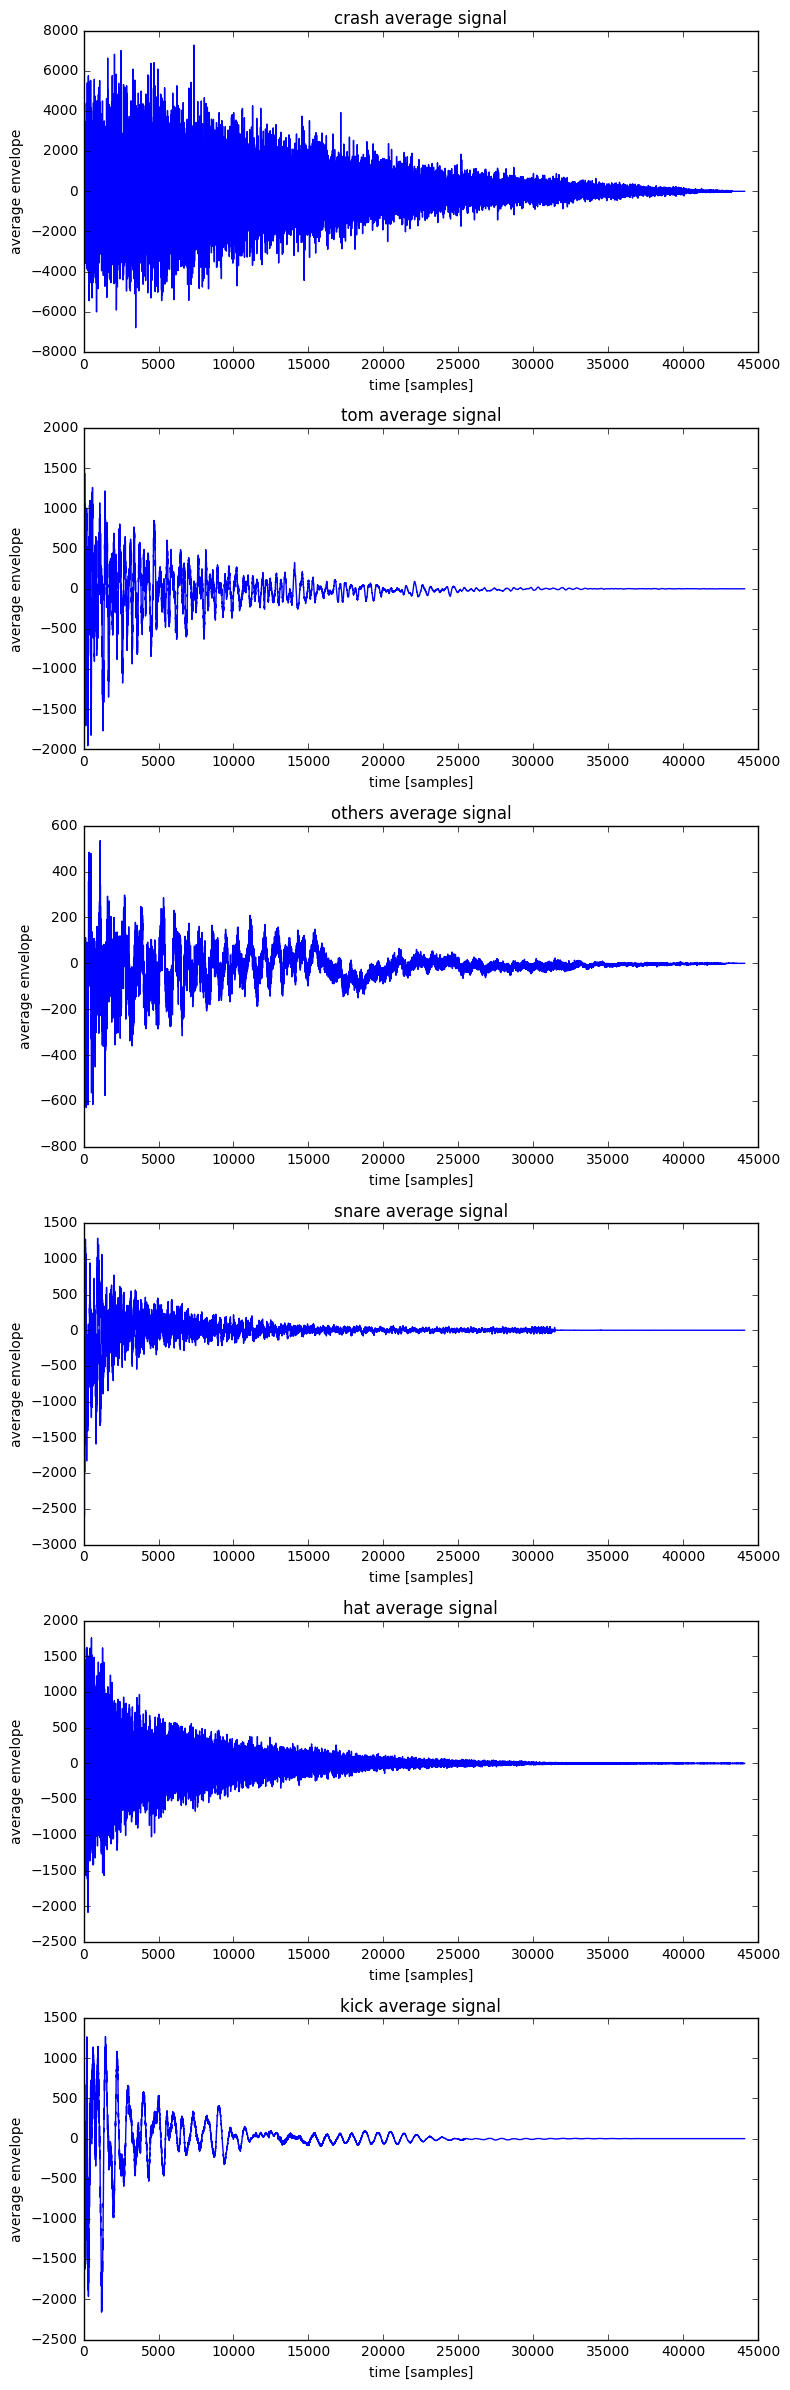

In [239]:
fig, axs = subplots(len(by_type), 1, figsize=(8, 4 * len(by_type)))
for ax, (k, avg) in zip(axs, by_type_avg.items()):
    sca(ax)
    plot(avg)
    xlabel('time [samples]')
    ylabel('average envelope')
    title('{} average signal'.format(k))
tight_layout()